# **Imports**

In [2]:
import pandas as pd
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from K_means import *
from sklearn.datasets import make_blobs
from numpy import dot
from numpy.linalg import norm
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import eigs, eigsh
from spectral_clustering import *
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer

# **Data imports**

## Blob

In [2]:
# generate synthetic data

# parameters
n_samples = 200
n_features = 20
n_clusters = 3

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)

sc = StandardScaler()
sc.fit(X)
X_std= sc.transform(X)

df = pd.DataFrame(X_std)
df['True_Label'] = y

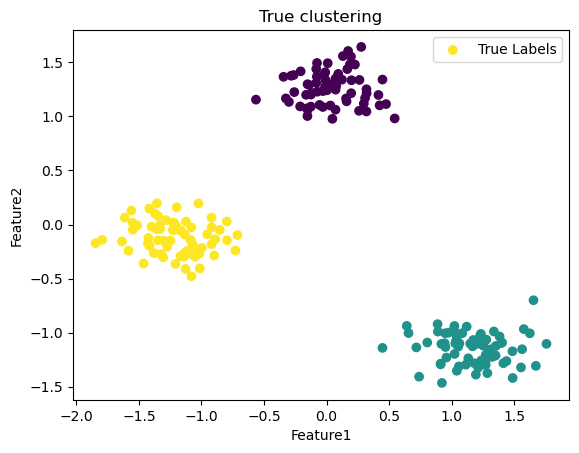

In [3]:
# visualize true clustering (we project on the first two dimensions)
plt.scatter(df[0], df[1], c=df['True_Label'], cmap='viridis', label='True Labels')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('True clustering')
plt.legend()
plt.show()

# **Functions**

In [4]:
def create_test_dataset_missing_data(d: int, n_points: int, mu_list: list, p: float) -> np._typing.NDArray:
    # return K-mixture model with n points in each cluster and delete data with proportion p for each point
    K = len(mu_list)
    X = [0.5 * np.random.randn(d, n_points) + mu_list[k][:, np.newaxis] for k in range(K)]
    X = np.hstack(X)
    mask = np.random.binomial(1, p, (d, len(mu_list) * n_points))
    X[np.where(mask)] = np.nan
    true_clusters = np.hstack([np.full(n_points, k, dtype=np.int8) for k in range(K)])
    return X, true_clusters

In [5]:
def compute_confusion_matrix(clusters:np._typing.NDArray, true_clusters:np._typing.NDArray, k:int)->np._typing.NDArray:
    #  at index i, j: number of elements of cluster i classified as being in cluster j
    N = clusters.shape[0]
    confusion_matrix = np.zeros((k, k))
    for i in range(N):
        confusion_matrix[true_clusters[i], clusters[i]] += 1
    return confusion_matrix

In [3]:
def inpute_data(X, k):
    # Inpute the data which misses values with a k-nearest neighboor search
    imputer = KNNImputer(n_neighbors=k)
    return imputer.fit_transform(X)

# **Measures**

In [6]:
d = 20
K=4
n = 1000
N = n*K

In [ ]:
missing_data_proportion=[1e-2, 5*1e-2, 1e-1, 2.5*1e-1, 5*1e-1, 7.5*1e-1]
nbr_samples = 50
number_correctly_classified_regular={p: np.zeros(K) for p in missing_data_proportion}
number_correctly_classified_spectral={p: np.zeros(K) for p in missing_data_proportion}
for it_samples in range(nbr_samples):

    kmeans_regular = {p: generalized_Kmeans(K, 'forgy', epochs=10) for p in missing_data_proportion}
    kmeans_spectral = {p: spectral_clustering(gaussian_similarity_function, 3, 4, 'k_nearest_neighbors', True, 'sym', compute_matrix_U_ARPACK) for p in missing_data_proportion}
    confusion_matrix_regular = dict()
    confusion_matrix_spectral = dict()
    
    for p in missing_data_proportion:

        X, true_clusters = create_test_dataset_missing_data(d, n, mu_list, p)
        X = inpute_data(X, 5)

        # Kmeans++
        kmeans_regular[p].fit(X.transpose())
        clusters_regular = kmeans_regular[p].predict(X.transpose())
        clusters_regular = np.round(clusters_regular).astype(int)
        confusion_matrix_regular[p] = compute_confusion_matrix(clusters_regular, true_clusters, K)
        number_correctly_classified_regular[p] = number_correctly_classified_regular[p]+np.sum(np.max(confusion_matrix_regular[p], axis=1))
        
        # spectral Kmeans
        kmeans_spectral[p].fit(X.transpose())
        clusters_spectral = kmeans_spectral[p].predict(X.transpose())
        clusters_spectral = np.round(clusters_spectral).astype(int)
        confusion_matrix_spectral[p] = compute_confusion_matrix(clusters_spectral, true_clusters, K)
        number_correctly_classified_spectral[p] = number_correctly_classified_spectral[p]+np.sum(np.max(confusion_matrix_spectral[p], axis=1))

for p in missing_data_proportion:

    number_correctly_classified_regular[p]/=nbr_samples
    number_correctly_classified_spectral[p]/=nbr_samples


print(number_correctly_classified_regular)
print(number_correctly_classified_spectral)

plt.plot(list(number_correctly_classified_regular.keys()), list(number_correctly_classified_regular.values()))
plt.plot(list(number_correctly_classified_spectral.keys()), list(number_correctly_classified_spectral.values()))
plt.xlabel("Proportion missing data")
plt.ylabel("Number of correctly classified points")
plt.title("Efficiency of spectral-guided and normal kmeans with missing values")
plt.show()